In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio as rio
from rasterio.plot import reshape_as_image
from rasterio.windows import Window,from_bounds
import geopandas as gpd

import matplotlib.pyplot as plt
from src import _stretch_im

import os
from random import sample

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use("bmh")

In [4]:
class LoadImageData(Dataset):
    def __init__(self,dataset_path,image_path, transform=None):
        # data loading
        self.dataset = gpd.read_file(dataset_path)
        self.image_path = image_path
        self.n_samples = len(self.dataset)
        
        self.transform = transform
    def __len__(self):
        return self.n_samples

    def __getitem__(self,idx):
        image = rio.open(self.image_path)
        minx,miny,maxx,maxy = self.dataset.loc[idx, 'geometry'].bounds
        window = from_bounds(minx, miny, maxx, maxy, transform=image.transform)
        self.X = np.moveaxis(image.read(window=window ,resampling=0),0,-1)
        
        self.y = self.dataset.loc[idx,'value']
        
        if self.transform is not None:
            transformedX = self.transform(image = self.X)
            self.X = transformedX["image"]
            self.y = torch.tensor(self.y)
            
            
        return self.X,self.y

In [5]:
train_transform = A.Compose([A.RandomRotate90(),
                             A.HorizontalFlip(),
                             A.VerticalFlip(),
                             # ToTensorV2()
                            ])

In [6]:
img = LoadImageData('../data/train_data.geojson', '../data/Sentinel-2_B4328_10m.tif',transform = train_transform)

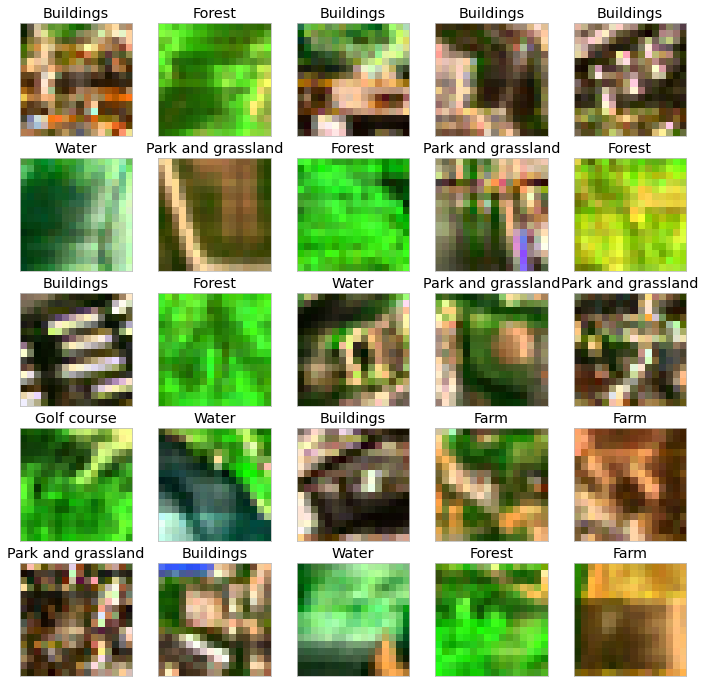

In [7]:
plt.figure(figsize=(12,12))
for i, j in enumerate(sample(range(0, 3000), 50)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    code = img[j][1]
    plt.imshow(np.clip(_stretch_im(img[j][0][...,:3],0),0,1))
    if code == 0:
        plt.title('Water')
    elif code == 1:
        plt.title('Golf course')
    elif code == 2:
        plt.title('Park and grassland')
    elif code == 3:
        plt.title('Buildings')
    elif code == 4:
        plt.title('Forest')
    elif code == 5:
        plt.title('Farm')
    if i==24:
        break